# Counterfactual Fairness Reproduction
### By Yunhao and Hugo
#### Original Paper: Counterfactual Fairness by Kusner, Loftus, Russell, and Silva (https://arxiv.org/abs/1703.06856)
#### This project takes the work of Potluri et al. on [Github](https://github.com/Kaaii/CS7290_Fairness_Eval_Project) as reference.


---



There are many machine learning algorithms that can and do automate decisions for complex issues such as receiving a loan, insurance pricing, predictive policing, prison sentences, etc. This  paper, by Kusner, Loftus, Russell, and Silva, seeks to develop a way to address whether a prediction is fair using tools from causal inference. Through causal modeling we can see how and where this unfairness is happening. Because algorithms use observed data to make predictions, data that may contain historical bias, (ex. racially biased police stop and frisk policies sexist/racist/ageist hiring policies) they can often result in unfair policy decisions. 

To understand how to evaluate fairness we must define what it means. Below are a definitions presented by the authors: 

- **Fairness through unawareness** – an algorithm does not use any protected attributes. If we have observations of a person’s race or sex we just ignore that information

- **Individual Fairness** – an algorithm gives similar predictions to similar individuals

- **Demographic Parity** – an algorithm gives the same prediction no matter what the value of the given predictor is

- **Equality of Opportunity** – an algorithm gives the same prediction given the outcome regardless of the protected attribute

- **Counterfactual Fairness** – Had any individual been of a different race, sex, etc. the prediction would not change

The authors believe that counterfactual fairness is the correct definition to use because we can make comparisons on an individual level. We are asking what would have happened if this same person was of a different race or sex.

## **Law School Success** 

We have considered the example of law school success to implement the algorithms discussed
in the paper. In this example, the law school wants candidates with good knowledge to succeed
in the law program. However, knowledge is an unobserved variable. The challenge was to make
sure the admissions process was fair to underprivileged groups. The college admissions panel
doesn't use candidates' racial or gender identity in determining whether to admit them into the
program or not. They'd only consider the undergraduate GPA and LSAT score to keep the
process fair. However, the admissions panel's decision might get indirectly influenced by
protected attributes like race and sex. Students from less privileged backgrounds may lack the
economic opportunity to enroll in LSAT preparation courses. The classroom performance may
not depend on knowledge alone but also be unduly affected by sensitive attributes that we do
not want to use as a basis for admissions. In this project, we implemented concepts like fairness
through unawareness and counterfactual fairness as discussed in the paper. We leveraged
these concepts to identify historical bias while estimating knowledge. 

The data could be found [here](https://www.kaggle.com/datasets/danofer/law-school-admissions-bar-passage
) on Kaggle.

To construct causal models, we've used `Pyro`, which is a probabilistic programming language built on Python and PyTorch. A general introduction can be found [here](https://pyro.ai/examples/intro_long.html).

## Preparation

In [9]:
%%capture
!pip3 install pyro-ppl 
!pip3 install torch 
!pip3 install tqdm
!pip3 install seaborn
!pip3 install scikit-learn

In [19]:
import os
import pickle
from tqdm import tqdm
import torch 
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pyro
import pyro.distributions as dist
from torch import nn
import seaborn as sns
from pyro.nn import PyroModule
from sklearn.model_selection import train_test_split

In [11]:
data_df = pd.read_csv("../data/law_data.csv")

In [13]:
cols = ["sex", "race", "UGPA", "LSAT", "ZFYA"]
data_df = data_df[cols]
data_df.dropna(inplace=True)

/tmp/ipykernel_3905720/3131208841.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_df.dropna(inplace=True)


In [23]:
data_df

,sex,race,ugpa,lsat,zfygpa
0,1.0,7.0,3.5,44.0,1.33
1,1.0,7.0,3.5,29.0,-0.11
2,2.0,7.0,3.5,36.0,-0.64
3,2.0,7.0,3.5,39.0,0.34
4,2.0,7.0,3.5,48.0,1.02
...,...,...,...,...,...
22402,2.0,3.0,1.8,26.5,-0.58
22403,2.0,3.0,1.8,19.7,-0.64
22404,2.0,3.0,1.8,36.0,0.41
22405,2.0,7.0,1.5,44.0,1.88


In [14]:
# split the dataset 80/20 into a train/test set, preserving label balance
train_set, test_set = train_test_split(data_df, test_size=0.2, stratify=data_df[['sex', 'race']],  random_state=42)

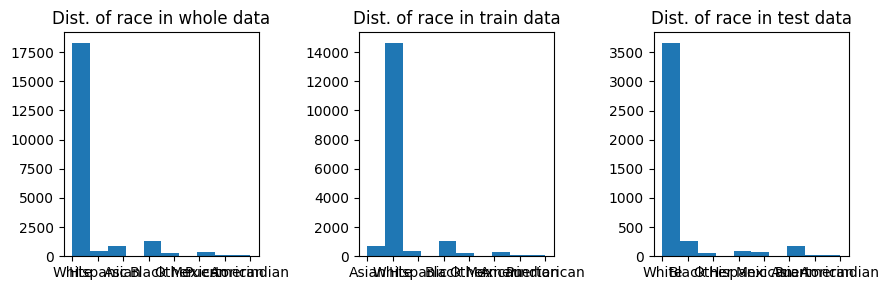

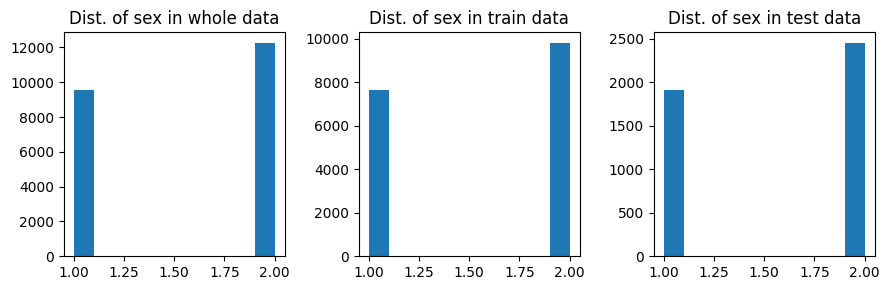

In [15]:
# check the distribution of sex and race in split
for attr in ["race", "sex"]:
  f, axes = plt.subplots(1, 3)
  for ax, dataset, name in zip(axes, [data_df, train_set, test_set], ["whole", "train", "test"]):
    ax.hist(dataset[attr])
    ax.set_title(f"Dist. of {attr} in {name} data")
    f.tight_layout()
    f.set_size_inches(9, 3)
plt.show()

In [16]:
# for CI testing
# smoke_test = ('CI' in os.environ)
pyro.enable_validation(True)
pyro.set_rng_seed(1)
pyro.enable_validation(True)

# setup
assert issubclass(PyroModule[nn.Linear], nn.Linear)
assert issubclass(PyroModule[nn.Linear], PyroModule)

In [20]:
def train_linear_model(x_train, y_train):

  lin_model = PyroModule[nn.Linear](x_train.shape[1], 1)
  loss_fn = torch.nn.MSELoss()
  optim = torch.optim.Adam(lin_model.parameters(), lr=0.05)
  num_iterations = 500

  def train():
      y_pred = lin_model(x_train).squeeze(-1)
      loss = loss_fn(y_pred, y_train)
      optim.zero_grad()
      loss.backward()
      optim.step()
      return loss

  for j in range(num_iterations):
      loss = train()
      if (j + 1) % 300 == 0:
          print("[iteration %04d] RMSE loss: %.4f" % (j + 1, np.square(loss.item())))
  print("Learned parameters:")
  for name, param in lin_model.named_parameters():
      print(name, param.data.numpy())
  return lin_model

## Unaware Model

An algorithm is fair so long as any protected attributes, in our example, Race and Sex, are not explicitly used in the decision-making process. However, it has a clear shortcoming as elements of X can contain discriminatory information analogous to protected attributes that may not be obvious at first.

To replicate this model, we have considered only the attributes GPA and LSAT.
The First year average(F) is predicted using the GPA(G) and LSAT(L). 

From the DAG, we can understand that it is indirectly biased because the Race(R) and Sex(S) are parents of GPA and LSAT.

We have then set up the Linear Regression in PyroModule to predict the first year average(F)
from GPA and LSAT.

In [21]:
unaware_sample_train = torch.tensor(train_set[["UGPA", "LSAT", "ZFYA"]].values, dtype=torch.float32)
unaware_sample_test = torch.tensor(test_set[["UGPA", "LSAT", "ZFYA"]].values, dtype=torch.float32)
train_x_unaware, train_y_unaware = unaware_sample_train[:, :-1], unaware_sample_train[:, -1]
test_x_unaware, test_y_unaware = unaware_sample_test[:, :-1], unaware_sample_test[:, -1]

model_unaware = train_linear_model(train_x_unaware, train_y_unaware)

[iteration 0300] RMSE loss: 0.7574
Learned parameters:
weight [[0.05279277 0.01651701]]
bias [-0.6547668]


In [22]:
loss_fn = torch.nn.MSELoss()
y_pred = model_unaware(test_x_unaware).squeeze(-1)
loss = loss_fn(y_pred, test_y_unaware).item()
print(f"Unaware Model: RMSE on test samples = {np.square(loss):.4f}")

Unaware Model: RMSE on test samples = 0.6633


### Visualization

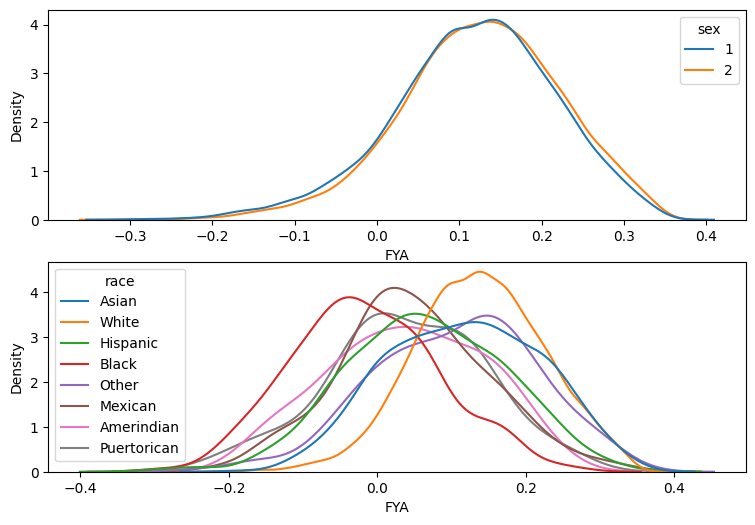

In [23]:
# Look at distribution of FYA on difference races and sex on train set
fit = train_set.copy()
fit["FYA"] = model_unaware(train_x_unaware).detach().numpy()
f, (ax1, ax2) = plt.subplots(2)
f.set_size_inches(9, 6)

sns.kdeplot(x="FYA", data=fit, hue="sex", ax=ax1, legend=True, common_norm=False, palette = sns.color_palette(n_colors=2))
sns.kdeplot(x="FYA", data=fit, hue="race", ax=ax2, legend=True, common_norm=False, palette = sns.color_palette(n_colors=8))
plt.show()

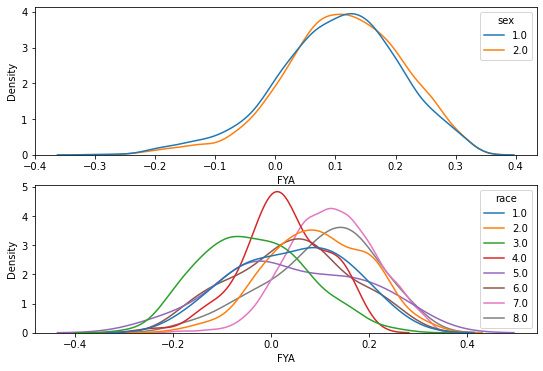

In [31]:
# Look at distribution of FYA on difference races and sex on test set
fit = test_set.copy()
fit["FYA"] = model_unaware(test_x_unaware).detach().numpy()

f, (ax1, ax2) = plt.subplots(2)
f.set_size_inches(9, 6)

sns.kdeplot(x="FYA", data=fit, hue="sex", ax=ax1, legend=True, common_norm=False, palette = sns.color_palette(n_colors=2))
sns.kdeplot(x="FYA", data=fit, hue="race", ax=ax2, legend=True, common_norm=False, palette = sns.color_palette(n_colors=8))
plt.show()

## Full Model

This model uses all the available observed variables
to predict FYA(F). 

Just as noticed in the paper, this model uses all the observed variables, it achieves a lower RMSE loss. However it clearly is biased since it uses protected attributes race and sex directly in its decision making. The
resulting density plots illustrates the obvious biase on race. 

We have similarly built the Linear Regression model to predict FYA(F) using race, sex, GPA
and LSAT.

In [24]:
full_sample_train = torch.tensor(train_set[["sex", "race", "UGPA", "LSAT", "ZFYA"]].values, dtype=torch.float32)
full_sample_test = torch.tensor(test_set[["sex", "race", "UGPA", "LSAT", "ZFYA"]].values, dtype=torch.float32)
train_x_full, train_y_full = full_sample_train[:, :-1], full_sample_train[:, -1]
test_x_full, test_y_full = full_sample_test[:, :-1], full_sample_test[:, -1]

model_full = train_linear_model(train_x_full, train_y_full)

TypeError: can't convert np.ndarray of type numpy.object_. The only supported types are: float64, float32, float16, complex64, complex128, int64, int32, int16, int8, uint8, and bool.

In [33]:
loss_fn = torch.nn.MSELoss()
y_pred = model_full(test_x_full).squeeze(-1)
loss = loss_fn(y_pred, test_y_full).item()
print(f"Full Model: RMSE on test samples = {np.square(loss):.4f}")

Full Model: RMSE on test samples = 0.6152


### Visualization

In [25]:
# Look at distribution of FYA on difference races and sex on train set
fit = train_set.copy()
fit["FYA"] = model_full(train_x_full).detach().numpy()

f, (ax1, ax2) = plt.subplots(2)
f.set_size_inches(9, 6)
sns.kdeplot(x="FYA", data=fit, hue="sex", ax=ax1, legend=True, common_norm=False, palette = sns.color_palette(n_colors=2))
sns.kdeplot(x="FYA", data=fit, hue="race", ax=ax2, legend=True, common_norm=False, palette = sns.color_palette(n_colors=8))
plt.show()

NameError: name 'model_full' is not defined

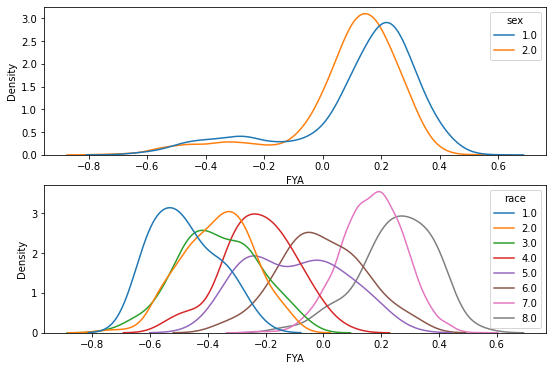

In [35]:
# Look at distribution of FYA on difference races and sex on test set
fit = test_set.copy()
fit["FYA"] = model_full(test_x_full).detach().numpy()

f, (ax1, ax2) = plt.subplots(2)
f.set_size_inches(9, 6)
sns.kdeplot(x="FYA", data=fit, hue="sex", ax=ax1, legend=True, common_norm=False, palette = sns.color_palette(n_colors=2))
sns.kdeplot(x="FYA", data=fit, hue="race", ax=ax2, legend=True, common_norm=False, palette = sns.color_palette(n_colors=8))
plt.show()

## Fair K model

In this model, we infer Knowledge(K) (as it is a latent variable) and use it to predict FYA(F) instead of relying on the protected attributes race(R) and sex(S) which are parents of GPA(G) and LSAT(L). 

To achieve this, based on the causal graph and distributions proposed in the paper, we infer the posterior and marginal distribution of Knowledge(K) according to the observations. Then use the inferred K to predict FYA(F).

In [26]:
def LawSchoolModel(race, sex, gpa=None, lsat=None, fya=None):
    distributions = {
        'Inverse Gamma': dist.InverseGamma(torch.tensor(1.), torch.tensor(1.)), 
        'Standard Normal': dist.Normal(torch.tensor(0.), torch.tensor(1.)),
    }

    k = pyro.sample("k", distributions['Standard Normal'])
    gpa0 = pyro.sample("gpa0", distributions['Standard Normal'])
    w_k_gpa = pyro.sample("w_k_gpa", distributions['Standard Normal'])
    w_r_gpa = pyro.sample("w_r_gpa", distributions['Standard Normal'])
    w_s_gpa = pyro.sample("w_s_gpa", distributions['Standard Normal'])
    lsat0 = pyro.sample("lsat0", distributions['Standard Normal'])
    w_k_lsat = pyro.sample("w_k_lsat", distributions['Standard Normal'])
    w_r_lsat = pyro.sample("w_r_lsat", distributions['Standard Normal'])
    w_s_lsat = pyro.sample("w_s_lsat", distributions['Standard Normal'])
    w_k_fya = pyro.sample("w_k_fya", distributions['Standard Normal'])
    w_r_fya = pyro.sample("w_r_fya", distributions['Standard Normal'])
    w_s_fya = pyro.sample("w_s_fya", distributions['Standard Normal'])
    sigma_gpa_square = pyro.sample("sigma_gpa_sq", distributions['Inverse Gamma'])

    mean_gpa = gpa0 + k * w_k_gpa + race * w_r_gpa + sex * w_s_gpa 
    param_lsat = lsat0 + k * w_k_lsat + race * w_r_lsat + sex * w_s_lsat
    mean_fya = k * w_k_fya + race * w_r_fya + sex * w_s_fya
    with pyro.plate("data", len(race)):
      gpa = pyro.sample("gpa", dist.Normal(mean_gpa, torch.square(sigma_gpa_square)), obs=gpa)
      lsat = pyro.sample("lsat", dist.Poisson(param_lsat.exp()), obs=lsat)
      fya = pyro.sample("fya", dist.Normal(mean_fya, 1), obs=fya)
      return gpa, lsat, fya

In [27]:
data_tensor = torch.tensor(train_set.values, dtype=torch.float32)
data_test_tensor = torch.tensor(test_set.values, dtype=torch.float32)

TypeError: can't convert np.ndarray of type numpy.object_. The only supported types are: float64, float32, float16, complex64, complex128, int64, int32, int16, int8, uint8, and bool.

/usr/local/lib/python3.9/dist-packages/torch/cuda/__init__.py:497: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


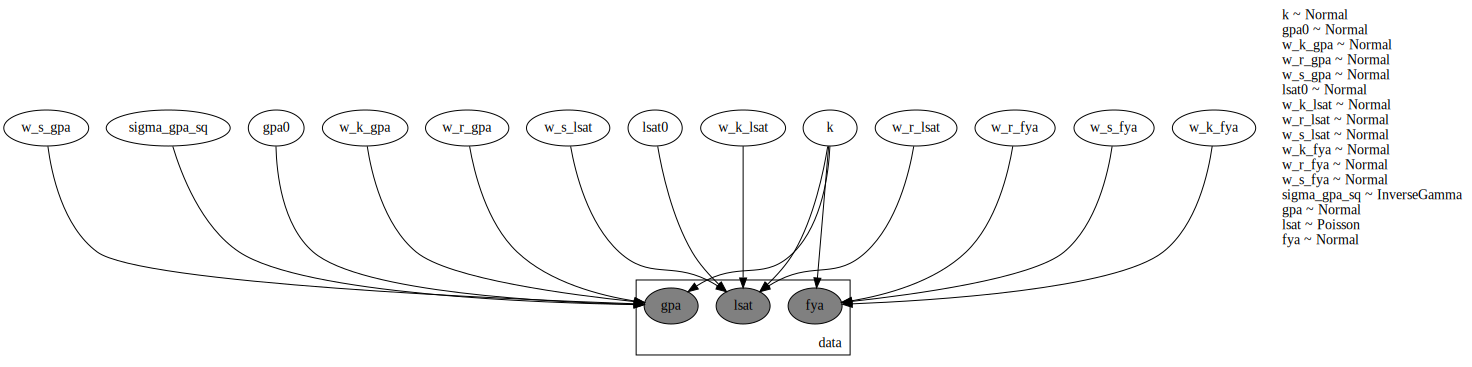

In [38]:
model_graph = pyro.render_model(LawSchoolModel, model_args=(data_tensor[:, 0], data_tensor[:, 1], data_tensor[:, 2], data_tensor[:, 3], data_tensor[:, 4]), render_distributions=True, render_params=True)
model_graph

### Infer K

Iterating through the generated samples to use the observed variables GPA, LSAT and FYA to infer
samples for knowledge(K)

In [73]:
K_list = []
for i in tqdm(range(data_tensor.shape[0])):
  conditioned = pyro.condition(LawSchoolModel, data={"gpa": data_tensor[i, 2], "lsat": data_tensor[i, 3].type(torch.int32), "fya": data_tensor[i, 4]})

  posterior = pyro.infer.Importance(conditioned, num_samples=10)
  marginal = pyro.infer.EmpiricalMarginal(posterior.run(race=data_tensor[:, 0], sex=data_tensor[:, 1]), sites="k")
  K_list.append(marginal.mean)

with open('inferred_K_train.pkl', 'wb') as f:
  pickle.dump(K_list, f)

100%|██████████| 17124/17124 [30:18<00:00,  9.42it/s]


In [85]:
K_list_test = []
for i in tqdm(range(data_test_tensor.shape[0])):
  conditioned = pyro.condition(LawSchoolModel, data={"gpa": data_test_tensor[i, 2], "lsat": data_test_tensor[i, 3].type(torch.int32), "fya": data_test_tensor[i, 4]})
  posterior = pyro.infer.Importance(conditioned, num_samples=10)
  marginal = pyro.infer.EmpiricalMarginal(posterior.run(race=data_test_tensor[:, 0], sex=data_test_tensor[:, 1]), sites="k")
  K_list_test.append(marginal.mean)

with open('inferred_K_test.pkl', 'wb') as f:
  pickle.dump(K_list_test, f)

100%|██████████| 4282/4282 [06:38<00:00, 10.74it/s]


In [41]:
with open('./inferred_K_train.pkl', 'rb') as f:
  K_list = pickle.load(f)

with open('./inferred_K_test.pkl', 'rb') as f:
  K_list_test = pickle.load(f)

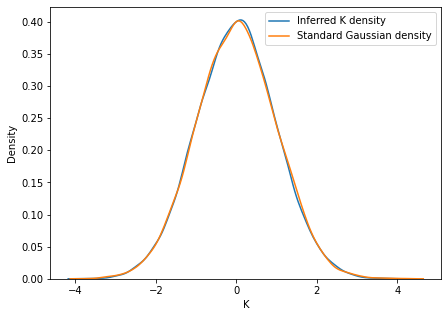

In [63]:
# plt.hist(K_list)
plt.figure(figsize=(7, 5))
sns.kdeplot(np.array(K_list), label="Inferred K density")
sns.kdeplot(np.random.randn(10000), label="Standard Gaussian density")
plt.xlabel("K")
plt.legend()
plt.show()

### Predict FYA

Now use our new inferred K into the Linear Reg Model to predict F

In [45]:
x_data, y_data = torch.tensor(K_list, dtype=torch.float32).reshape(-1,1), data_tensor[:, -1]

model_fairK = train_linear_model(x_data, y_data)

[iteration 0300] RMSE loss: 0.7428
Learned parameters:
weight [[-0.00048296]]
bias [0.083131]


In [46]:
loss_fn = torch.nn.MSELoss()
y_pred_test = model_fairK(torch.tensor(K_list_test, dtype=torch.float32).reshape(-1,1)).squeeze(-1)
loss = loss_fn(y_pred_test, data_test_tensor[:, -1]).item()
print(f"Fair K Model: RMSE on test samples = {np.square(loss):.4f}")

Fair K Model: RMSE on test samples = 0.7464


### Visualization

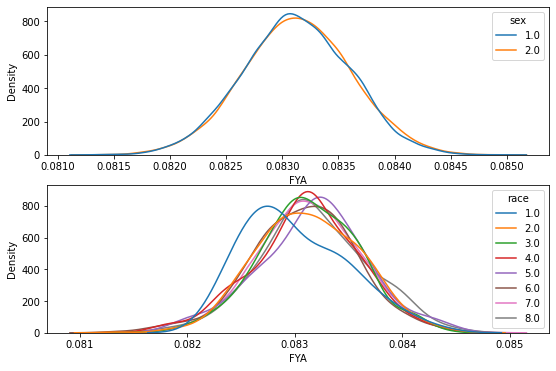

In [47]:
# Look at distribution of FYA on difference races and sex on train set
fit = train_set.copy()
fit["FYA"] = model_fairK(x_data).detach().numpy()

f, (ax1, ax2) = plt.subplots(2)
f.set_size_inches(9, 6)
sns.kdeplot(x="FYA", data=fit, hue="sex", ax=ax1, legend=True, common_norm=False, palette = sns.color_palette(n_colors=2))
sns.kdeplot(x="FYA", data=fit, hue="race", ax=ax2, legend=True, common_norm=False, palette = sns.color_palette(n_colors=8))
plt.show()

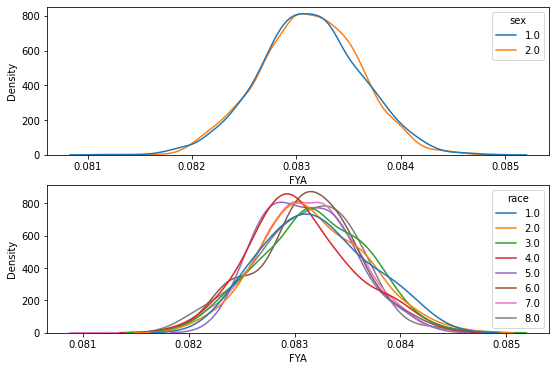

In [48]:
# Look at distribution of FYA on difference races and sex on test set
fit = test_set.copy()
fit["FYA"] = y_pred_test.detach().numpy()

f, (ax1, ax2) = plt.subplots(2)
f.set_size_inches(9, 6)
sns.kdeplot(x="FYA", data=fit, hue="sex", ax=ax1, legend=True, common_norm=False, palette = sns.color_palette(n_colors=2))
sns.kdeplot(x="FYA", data=fit, hue="race", ax=ax2, legend=True, common_norm=False, palette = sns.color_palette(n_colors=8))
plt.show()

As we see from the above density plots, the predicitions separated out by the protected attributes Race and Sex are overlapping. This is expected under the counterfactual fairness algorithim created by the authors. Inferring the Latent variable K which is not a child of the protected attributes allowed us to make predictions that are counterfactually fair.

## Fair Add model

In [49]:
race_sex_tensor_train = torch.tensor(train_set[["race", "sex"]].values, dtype=torch.float32)
gpa_tensor_train = torch.tensor(train_set[["ugpa"]].values, dtype=torch.float32)[:, 0]
lsat_tensor_train = torch.tensor(train_set[["lsat"]].values, dtype=torch.float32)[:, 0]

print("-"*20)
print("Predict GPA based on race and sex:")
model_gpa_rs = train_linear_model(race_sex_tensor_train, gpa_tensor_train)

print("-"*20)
print("Predict LSAT based on race and sex:")
model_lsat_rs = train_linear_model(race_sex_tensor_train, lsat_tensor_train)

--------------------
Predict GPA based on race and sex:
[iteration 0300] RMSE loss: 0.0253
Learned parameters:
weight [[ 0.05497793 -0.11941855]]
bias [3.0430079]
--------------------
Predict LSAT based on race and sex:
[iteration 0300] RMSE loss: 2242.6073
Learned parameters:
weight [[3.6855626 4.3101883]]
bias [5.3976493]


In [50]:
gpa_tensor_resid = gpa_tensor_train - model_gpa_rs(race_sex_tensor_train).detach().squeeze(0).numpy()[:, 0]
lsat_tensor_resid = lsat_tensor_train - model_lsat_rs(race_sex_tensor_train).detach().squeeze(0).numpy()[:, 0]

x_fair_add = torch.stack((gpa_tensor_resid, lsat_tensor_resid), dim=1)
y_fair_add = torch.tensor(train_set[["zfygpa"]].values, dtype=torch.float32)[:, 0]
print("Predict FYA based on residuals of GPA and LSAT:")
model_fair_add = train_linear_model(x_fair_add, y_fair_add)

Predict FYA based on residuals of GPA and LSAT:
[iteration 0300] RMSE loss: 0.7163
Learned parameters:
weight [[ 0.32155684 -0.00268231]]
bias [0.08480211]


In [53]:
race_sex_tensor_test = torch.tensor(test_set[["race", "sex"]].values, dtype=torch.float32)
gpa_tensor_test = torch.tensor(test_set[["ugpa"]].values, dtype=torch.float32)[:, 0]
lsat_tensor_test = torch.tensor(test_set[["lsat"]].values, dtype=torch.float32)[:, 0]

gpa_tensor_resid_test = gpa_tensor_test - model_gpa_rs(race_sex_tensor_test).detach().squeeze(0).numpy()[:, 0]
lsat_tensor_resid_test = lsat_tensor_test - model_lsat_rs(race_sex_tensor_test).detach().squeeze(0).numpy()[:, 0]

x_fair_add_test = torch.stack((gpa_tensor_resid_test, lsat_tensor_resid_test), dim=1)
y_fair_add_test = torch.tensor(test_set[["zfygpa"]].values, dtype=torch.float32)[:, 0]

loss_fn = torch.nn.MSELoss()
y_pred_test = model_fair_add(x_fair_add_test).squeeze(-1)
loss = loss_fn(y_pred_test, y_fair_add_test).item()
print(f"Fair add Model: RMSE on test samples = {np.square(loss):.4f}")

Fair add Model: RMSE on test samples = 0.7227


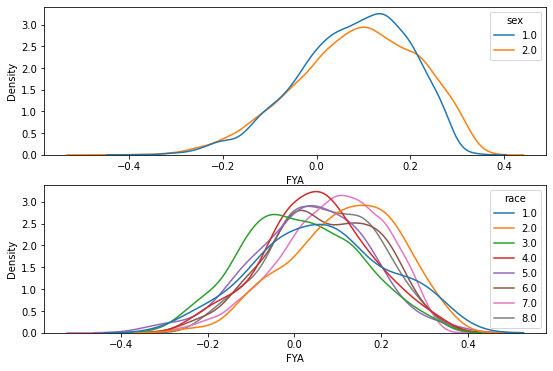

In [51]:
# Look at distribution of FYA on difference races and sex on train set
fit = train_set.copy()
fit["FYA"] = model_fair_add(x_fair_add).detach().numpy()

f, (ax1, ax2) = plt.subplots(2)
f.set_size_inches(9, 6)
sns.kdeplot(x="FYA", data=fit, hue="sex", ax=ax1, legend=True, common_norm=False, palette = sns.color_palette(n_colors=2))
sns.kdeplot(x="FYA", data=fit, hue="race", ax=ax2, legend=True, common_norm=False, palette = sns.color_palette(n_colors=8))
plt.show()

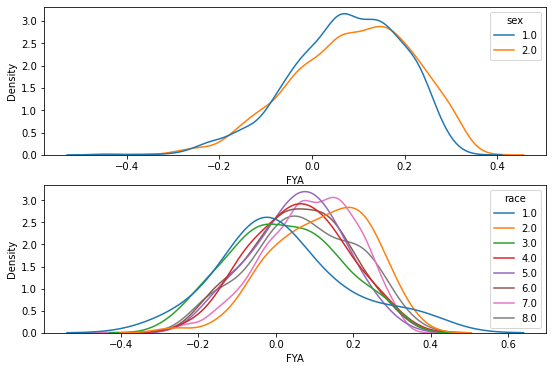

In [54]:
# Look at distribution of FYA on difference races and sex on test set
fit = test_set.copy()
fit["FYA"] = model_fair_add(x_fair_add_test).detach().numpy()

f, (ax1, ax2) = plt.subplots(2)
f.set_size_inches(9, 6)
sns.kdeplot(x="FYA", data=fit, hue="sex", ax=ax1, legend=True, common_norm=False, palette = sns.color_palette(n_colors=2))
sns.kdeplot(x="FYA", data=fit, hue="race", ax=ax2, legend=True, common_norm=False, palette = sns.color_palette(n_colors=8))
plt.show()

## Conculsions

Here are the RMSE loss on test dataset of four methods in the paper. All prediction models are linear regression. We observe the same trend as in the paper: 

- The **Full model** achieves the lowest RMSE as it uses race and sex to more accurately reconstruct FYA. 
- The (also unfair) **Unaware model** still uses the unfair variables GPA and LSAT, but because it does not use race and sex it cannot match the RMSE of the Full model. But if we look at the FYA distributions when protected attributes (sex and race) take different values, the unfairness is alleviated. 
- model **Fair K** uses weaker assumptions and thus the RMSE is highest. 
- Using the Level 3 assumptions, as in **Fair Add**, we produce a counterfactually fair model that trades slightly stronger assumptions for lower RMSE.

 |       |Full   | Unaware | Fair K | Fair Add | 
| ----- | ----- | ------- | -------| -------- |
| RMSE  | 0.615 | 0.671   | 0.746  | 0.723    | 




After the previous implementation of the counterfactual fairness, we take the protected attributes
into consideration, so we are able to take into account the different social biases that may arise
towards individuals based on ethically sensitive attributes and compensate for these biases
effectively. We share the authors beliefs that fairness should be regulated by explicitly modeling the causal structure of the world. Simply relying on probabilistic independence cannot meet the fair standard, it also cannot point out why and how unfairness is occurring. By implementing the previous counterfactual fairness models, we are able to provide practical solutions for solving a wide array of fairness modeling problems.